In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
from typing import Any
from torch import Tensor

2025-05-01 20:05:35.111923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746129935.138036      95 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746129935.146050      95 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Xception(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(Xception, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(True)

        self.block1 = XceptionBlock(64, 128, 2, False, True, 2)
        self.block2 = XceptionBlock(128, 256, 2, True, True, 2)
        self.block3 = XceptionBlock(256, 728, 2, True, True, 2)

        self.block4 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block5 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block6 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block7 = XceptionBlock(728, 728, 1, True, True, 3)

        self.block8 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block9 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block10 = XceptionBlock(728, 728, 1, True, True, 3)
        self.block11 = XceptionBlock(728, 728, 1, True, True, 3)

        self.block12 = XceptionBlock(728, 1024, 2, True, False, 2)

        self.conv3 = SeparableConv2d(1024, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = SeparableConv2d(1536, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(True)

        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

        self._initialize_weights()

    def forward(self, x: Tensor) -> Tensor:
        out = self._forward_impl(x)
        return out

    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.block8(out)
        out = self.block9(out)
        out = self.block10(out)
        out = self.block11(out)
        out = self.block12(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)

        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu4(out)

        out = self.global_average_pooling(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                torch.nn.init.trunc_normal_(module.weight, mean=0.0, std=0.1, a=-2, b=2)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

In [3]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super(SeparableConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, groups=in_channels, bias=False, **kwargs)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0),
                                   bias=False)

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.pointwise(out)
        return out

In [4]:
class XceptionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, relu_first: bool, grow_first: bool, repeat_times: int) -> None:
        super(XceptionBlock, self).__init__()
        rep = []

        if in_channels != out_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(stride, stride),
                                  padding=(0, 0), bias=False)
            self.skipbn = nn.BatchNorm2d(out_channels)
        else:
            self.skip = None

        mid_channels = in_channels
        if grow_first:
            rep.append(nn.ReLU(True))
            rep.append(SeparableConv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            rep.append(nn.BatchNorm2d(out_channels))
            mid_channels = out_channels

        for _ in range(repeat_times - 1):
            rep.append(nn.ReLU(True))
            rep.append(SeparableConv2d(mid_channels, mid_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            rep.append(nn.BatchNorm2d(mid_channels))

        if not grow_first:
            rep.append(nn.ReLU(True))
            rep.append(SeparableConv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            rep.append(nn.BatchNorm2d(out_channels))

        if not relu_first:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(False)

        if stride != 1:
            rep.append(nn.MaxPool2d((3, 3), (stride, stride), (1, 1)))

        self.rep = nn.Sequential(*rep)

    def forward(self, x: Tensor) -> Tensor:
        if self.skip is not None:
            identity = self.skip(x)
            identity = self.skipbn(identity)
        else:
            identity = x

        out = self.rep(x)
        out = torch.add(out, identity)
        return out

In [5]:
def xception(**kwargs: Any) -> Xception:
    return Xception(**kwargs)

In [6]:
# Hyperparameters
params_A = {
    'name': 'Model_A_Adam',
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 1e-4,
    'optimizer': 'adam'
}

params_B = {
    'name': 'Model_B_SGD',
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.01,
    'optimizer': 'sgd',
    'momentum': 0.9
}

NUM_CLASSES = 6
IMAGE_SIZE = (150, 150)


In [7]:
# Paths to dataset
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
VAL_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test"

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

In [8]:
def get_optimizer(name, model, lr, momentum=None):
    if name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        raise ValueError("Unsupported optimizer")

In [9]:
def train_and_validate(params):
    print(f"Training {params['name']}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = xception(num_classes=NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(params['optimizer'], model, params['learning_rate'], params.get('momentum'))

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    writer = SummaryWriter(log_dir=f"runs/{params['name']}")
    history = {'train_loss': [], 'val_accuracy': []}

    best_val_accuracy = 0.0
    
    for epoch in range(params['epochs']):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"{params['name']} Epoch {epoch+1}/{params['epochs']}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        history['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        history['val_accuracy'].append(val_accuracy)
        
        # save best model
        if epoch == 0 or val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"{params['name']}_best_model.pth")

        print(f"Epoch [{epoch+1}/{params['epochs']}], "
              f"Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)

    writer.close()

    # Final evaluation
    print(f"\nFinal Validation Report for {params['name']}:")
    print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {params['name']}")
    plt.show()

    return model, history, all_labels, all_preds


Training Model_A_Adam


Epoch [1/10], Loss: 0.9645, Train Acc: 0.6468, Val Acc: 0.7200


Epoch [2/10], Loss: 0.6078, Train Acc: 0.7760, Val Acc: 0.7557


Epoch [3/10], Loss: 0.4883, Train Acc: 0.8250, Val Acc: 0.7320


Epoch [4/10], Loss: 0.3830, Train Acc: 0.8638, Val Acc: 0.7787


Epoch [5/10], Loss: 0.3089, Train Acc: 0.8935, Val Acc: 0.7817


Epoch [6/10], Loss: 0.2577, Train Acc: 0.9103, Val Acc: 0.7940


Epoch [7/10], Loss: 0.2092, Train Acc: 0.9285, Val Acc: 0.8073


Epoch [8/10], Loss: 0.1769, Train Acc: 0.9407, Val Acc: 0.7883


Epoch [9/10], Loss: 0.1456, Train Acc: 0.9503, Val Acc: 0.7763


Epoch [10/10], Loss: 0.1314, Train Acc: 0.9567, Val Acc: 0.7847

Final Validation Report for Model_A_Adam:
              precision    recall  f1-score   support

   buildings       0.85      0.63      0.73       437
      forest       0.92      0.93      0.92       474
     glacier       0.85      0.63      0.72       553
    mountain       0.71      0.82      0.76       525
         sea       0.70      0.83      0.76       510
      street       0.76      0.86      0.81       501

    accuracy                           0.78      3000
   macro avg       0.80      0.79      0.78      3000
weighted avg       0.79      0.78      0.78      3000



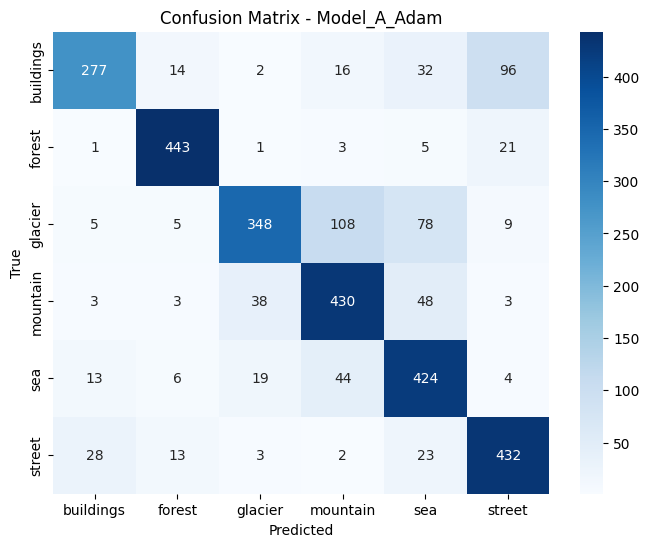

Training Model_B_SGD


Epoch [1/10], Loss: 1.1088, Train Acc: 0.6107, Val Acc: 0.7337


Epoch [2/10], Loss: 0.7188, Train Acc: 0.7443, Val Acc: 0.7937


Epoch [3/10], Loss: 0.6096, Train Acc: 0.7825, Val Acc: 0.7780


Epoch [4/10], Loss: 0.4846, Train Acc: 0.8240, Val Acc: 0.8237


Epoch [5/10], Loss: 0.4472, Train Acc: 0.8418, Val Acc: 0.8360


Epoch [6/10], Loss: 0.4146, Train Acc: 0.8533, Val Acc: 0.8377


Epoch [7/10], Loss: 0.3497, Train Acc: 0.8771, Val Acc: 0.8473


Epoch [8/10], Loss: 0.3258, Train Acc: 0.8826, Val Acc: 0.8430


Epoch [9/10], Loss: 0.2918, Train Acc: 0.8959, Val Acc: 0.8587


Epoch [10/10], Loss: 0.2688, Train Acc: 0.9027, Val Acc: 0.8430

Final Validation Report for Model_B_SGD:
              precision    recall  f1-score   support

   buildings       0.89      0.80      0.85       437
      forest       0.94      0.97      0.96       474
     glacier       0.69      0.91      0.78       553
    mountain       0.81      0.69      0.75       525
         sea       0.90      0.83      0.87       510
      street       0.91      0.85      0.88       501

    accuracy                           0.84      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.85      0.84      0.84      3000



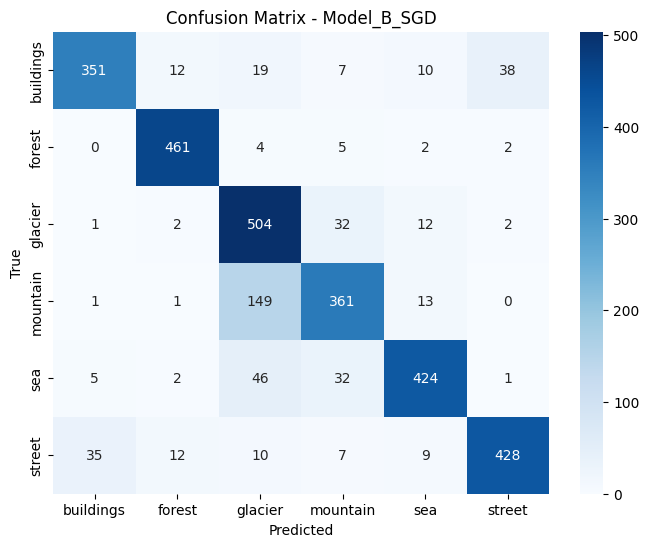

In [10]:
model_A, hist_A, labels_A, preds_A = train_and_validate(params_A)
model_B, hist_B, labels_B, preds_B = train_and_validate(params_B)

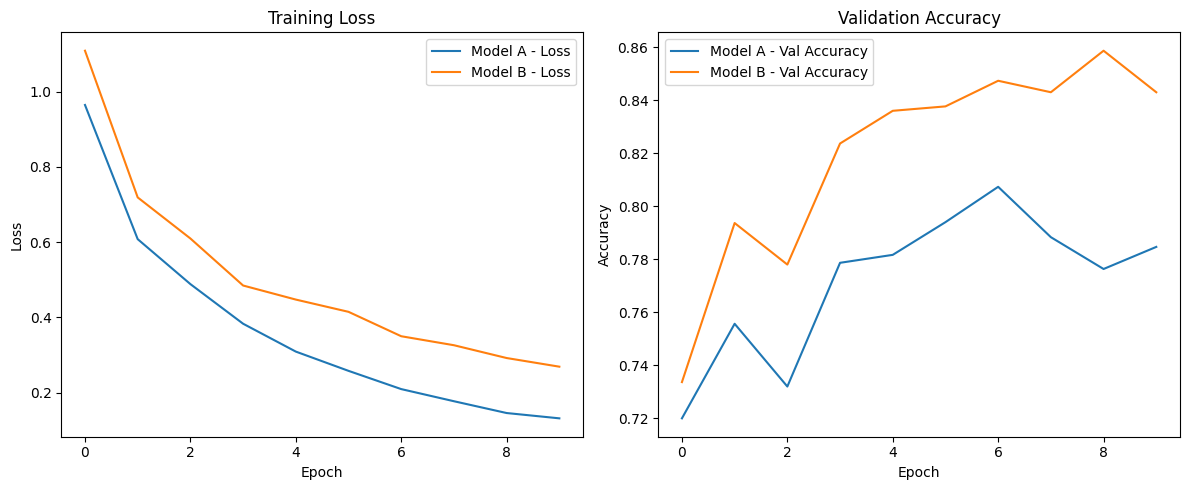

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_A['train_loss'], label='Model A - Loss')
plt.plot(hist_B['train_loss'], label='Model B - Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_A['val_accuracy'], label='Model A - Val Accuracy')
plt.plot(hist_B['val_accuracy'], label='Model B - Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>